In [40]:
#!unzip "/content/VisDrone2019-DET-val.zip" -d "/content/dataset"

In [41]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [42]:
def load_img(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def parse_annotations(img_path):
    label_path = img_path.replace('/images/', '/annotations/').replace('.jpg', '.txt')
    boxes = {}
    with open(label_path, 'r') as file:
        for line in file:
            vals = list(map(int, line.strip().split(',')))
            x, y, w, h, _, category_id, _, _ = vals
            boxes.setdefault(category_id, []).append((x, y, w, h))
    return boxes

In [43]:
def plot_image(img, boxes=None, label='Image'):
    temp = img.copy()
    if boxes:
        for (x, y, w, h) in boxes:
            cv2.rectangle(temp, (x, y), (x+w, y+h), (255, 0, 0), 2)
    plt.imshow(temp)
    plt.title(label)
    plt.axis('off')
    plt.show()

In [44]:
def compute_iou(b1, b2):
    x1, y1, w1, h1 = b1
    x2, y2, w2, h2 = b2
    xa = max(x1, x2)
    ya = max(y1, y2)
    xb = min(x1 + w1, x2 + w2)
    yb = min(y1 + h1, y2 + h2)

    if xa >= xb or ya >= yb:
        return 0.0

    inter = (xb - xa) * (yb - ya)
    area1 = w1 * h1
    area2 = w2 * h2
    return inter / min(area1, area2)

In [45]:
def apply_color_matching(src, ref):
    matched = src.astype(np.float32)
    ref = ref.astype(np.float32)

    mean_src, std_src = np.mean(matched, axis=(0,1)), np.std(matched, axis=(0,1))
    mean_ref, std_ref = np.mean(ref, axis=(0,1)), np.std(ref, axis=(0,1))

    adjusted = (matched - mean_src) * (std_ref / std_src) + mean_ref
    return np.clip(adjusted, 0, 255).astype(np.uint8)

In [46]:
def generate_sample(image_paths, target_class=4):
    bg_path = random.choice(image_paths)
    obj_path = random.choice(image_paths)

    bg_img = load_img(bg_path)
    src_img = load_img(obj_path)

    annots = parse_annotations(obj_path)
    objs = annots.get(target_class, [])

    result = bg_img.copy()
    placed_boxes = []
    corrected_patches = []

    for (x, y, w, h) in objs:
        patch = src_img[y:y+h, x:x+w]
        if patch.shape[0] == 0 or patch.shape[1] == 0:
            continue

        scale = np.random.uniform(0.8, 1.2)
        new_w, new_h = int(w * scale), int(h * scale)
        patch = cv2.resize(patch, (new_w, new_h))

        patch_corr = apply_color_matching(patch, bg_img)
        corrected_patches.append(patch_corr)

        for _ in range(10):
            px = random.randint(0, bg_img.shape[1] - new_w)
            py = random.randint(0, bg_img.shape[0] - new_h)
            box = (px, py, new_w, new_h)

            if all(compute_iou(box, b) < 0.5 for b in placed_boxes):
                center = (px + new_w // 2, py + new_h // 2)
                mask = 255 * np.ones_like(patch_corr, dtype=np.uint8)
                x_start, y_start = center[0] - patch_corr.shape[1] // 2, center[1] - patch_corr.shape[0] // 2
                x_end, y_end = x_start + patch_corr.shape[1], y_start + patch_corr.shape[0]

                if x_start >= 0 and y_start >= 0 and x_end <= result.shape[1] and y_end <= result.shape[0]:
                    try:
                        result = cv2.seamlessClone(patch_corr, result, mask, center, cv2.NORMAL_CLONE)
                        placed_boxes.append(box)
                        break
                    except Exception as e:
                        print(f"Skipping patch due to error: {e}")


    return bg_img, src_img, corrected_patches, result, placed_boxes

In [47]:
def visualize_result(bg_img, src_img, color_corrected_patches, final_img, placed_boxes):
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    axs[0, 0].imshow(bg_img)
    axs[0, 0].set_title("Original Background")
    axs[0, 0].axis("off")

    axs[0, 1].imshow(src_img)
    axs[0, 1].set_title("Source Image with Objects")
    axs[0, 1].axis("off")

    if color_corrected_patches:
        patch = color_corrected_patches[0]
        axs[1, 0].imshow(patch)
        axs[1, 0].set_title("Example Color-Corrected Object")
        axs[1, 0].axis("off")
    else:
        axs[1, 0].text(0.5, 0.5, 'No patches', ha='center', va='center')
        axs[1, 0].axis("off")

    img_with_boxes = final_img.copy()
    for (x, y, w, h) in placed_boxes:
        cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    axs[1, 1].imshow(img_with_boxes)
    axs[1, 1].set_title(f"Final Image: {len(placed_boxes)} objects")
    axs[1, 1].axis("off")

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.title("Histogram of Final Image")
    for i, col in enumerate(['r', 'g', 'b']):
        hist = cv2.calcHist([final_img], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)
    plt.grid(True)
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


In [48]:
def generate_dataset(image_paths, target_class=4, num_samples=500):
    X = []
    y_presence = []
    y_count = []

    for _ in range(num_samples):
        bg, src, corrected, final_img, boxes = generate_sample(image_paths, target_class)
        X.append(cv2.resize(final_img, (128, 128)))
        y_presence.append(1 if boxes else 0)
        y_count.append(len(boxes))

    X = np.array(X) / 255.0
    y_presence = np.array(y_presence)
    y_count = np.array(y_count)
    return X, y_presence, y_count

In [49]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_combined_model():
    base = ResNet50(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
    base.trainable = False

    inputs = Input(shape=(128, 128, 3))
    x = base(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)

    # Головка для классификации (наличие машин)
    presence_output = Dense(1, activation='sigmoid', name='presence')(x)

    # Головка для регрессии (количество машин)
    count_output = Dense(1, activation='linear', name='count')(x)

    model = Model(inputs=inputs, outputs=[presence_output, count_output])
    model.compile(
        optimizer='adam',
        loss={'presence': 'binary_crossentropy', 'count': 'mse'},
        metrics={'presence': 'accuracy', 'count': 'mae'}
    )
    return model

In [50]:
dataset_dir = '/content/dataset/VisDrone2019-DET-val'
img_dir = os.path.join(dataset_dir, 'images')
image_files = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.jpg')]

X, y_presence, y_count = generate_dataset(image_files, num_samples=500)

X_train, X_test, y_train_pres, y_test_pres = train_test_split(X, y_presence, test_size=0.2)
_, _, y_train_cnt, y_test_cnt = train_test_split(X, y_count, test_size=0.2)

combined_model = build_combined_model()

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]

history_combined = combined_model.fit(
    X_train, {'presence': y_train_pres, 'count': y_train_cnt},
    epochs=20,
    validation_data=(X_test, {'presence': y_test_pres, 'count': y_test_cnt}),
    callbacks=callbacks
)

Skipping patch due to error: OpenCV(4.11.0) /io/opencv/modules/core/src/matrix_wrap.cpp:1667: error: (-215:Assertion failed) !fixedSize() in function 'release'

Skipping patch due to error: OpenCV(4.11.0) /io/opencv/modules/core/src/matrix_wrap.cpp:1667: error: (-215:Assertion failed) !fixedSize() in function 'release'

Skipping patch due to error: OpenCV(4.11.0) /io/opencv/modules/core/src/matrix_wrap.cpp:1667: error: (-215:Assertion failed) !fixedSize() in function 'release'

Skipping patch due to error: OpenCV(4.11.0) /io/opencv/modules/core/src/matrix_wrap.cpp:1667: error: (-215:Assertion failed) !fixedSize() in function 'release'

Skipping patch due to error: OpenCV(4.11.0) /io/opencv/modules/core/src/matrix_wrap.cpp:1667: error: (-215:Assertion failed) !fixedSize() in function 'release'

Skipping patch due to error: OpenCV(4.11.0) /io/opencv/modules/core/src/matrix_wrap.cpp:1667: error: (-215:Assertion failed) !fixedSize() in function 'release'

Skipping patch due to error: OpenC

<ipython-input-45-04ee7d70c00a>:8: RuntimeWarning: divide by zero encountered in divide
  adjusted = (matched - mean_src) * (std_ref / std_src) + mean_ref
<ipython-input-45-04ee7d70c00a>:8: RuntimeWarning: invalid value encountered in multiply
  adjusted = (matched - mean_src) * (std_ref / std_src) + mean_ref
<ipython-input-45-04ee7d70c00a>:9: RuntimeWarning: invalid value encountered in cast
  return np.clip(adjusted, 0, 255).astype(np.uint8)


Skipping patch due to error: OpenCV(4.11.0) /io/opencv/modules/core/src/matrix.cpp:806: error: (-215:Assertion failed) 0 <= roi.x && 0 <= roi.width && roi.x + roi.width <= m.cols && 0 <= roi.y && 0 <= roi.height && roi.y + roi.height <= m.rows in function 'Mat'

Skipping patch due to error: OpenCV(4.11.0) /io/opencv/modules/core/src/matrix.cpp:806: error: (-215:Assertion failed) 0 <= roi.x && 0 <= roi.width && roi.x + roi.width <= m.cols && 0 <= roi.y && 0 <= roi.height && roi.y + roi.height <= m.rows in function 'Mat'

Skipping patch due to error: OpenCV(4.11.0) /io/opencv/modules/core/src/matrix.cpp:806: error: (-215:Assertion failed) 0 <= roi.x && 0 <= roi.width && roi.x + roi.width <= m.cols && 0 <= roi.y && 0 <= roi.height && roi.y + roi.height <= m.rows in function 'Mat'

Skipping patch due to error: OpenCV(4.11.0) /io/opencv/modules/core/src/matrix.cpp:806: error: (-215:Assertion failed) 0 <= roi.x && 0 <= roi.width && roi.x + roi.width <= m.cols && 0 <= roi.y && 0 <= roi.height

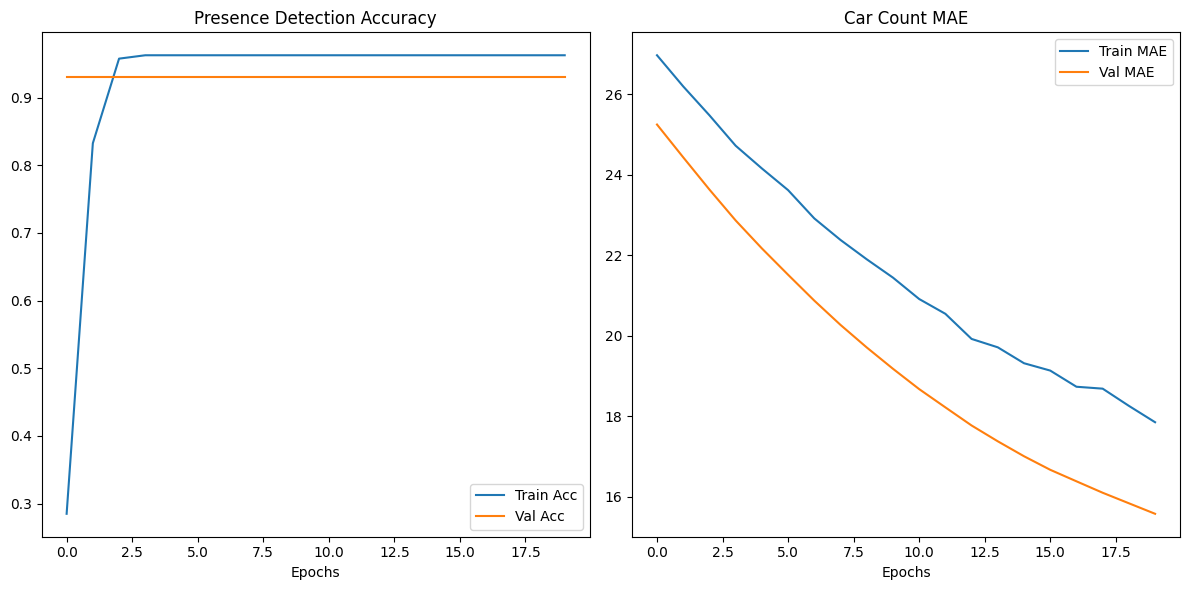

In [51]:
def plot_combined_history(history):
    plt.figure(figsize=(12, 6))

    # Классификация
    plt.subplot(1, 2, 1)
    plt.plot(history.history['presence_accuracy'], label='Train Acc')
    plt.plot(history.history['val_presence_accuracy'], label='Val Acc')
    plt.title("Presence Detection Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Регрессия
    plt.subplot(1, 2, 2)
    plt.plot(history.history['count_mae'], label='Train MAE')
    plt.plot(history.history['val_count_mae'], label='Val MAE')
    plt.title("Car Count MAE")
    plt.xlabel("Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_combined_history(history_combined)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


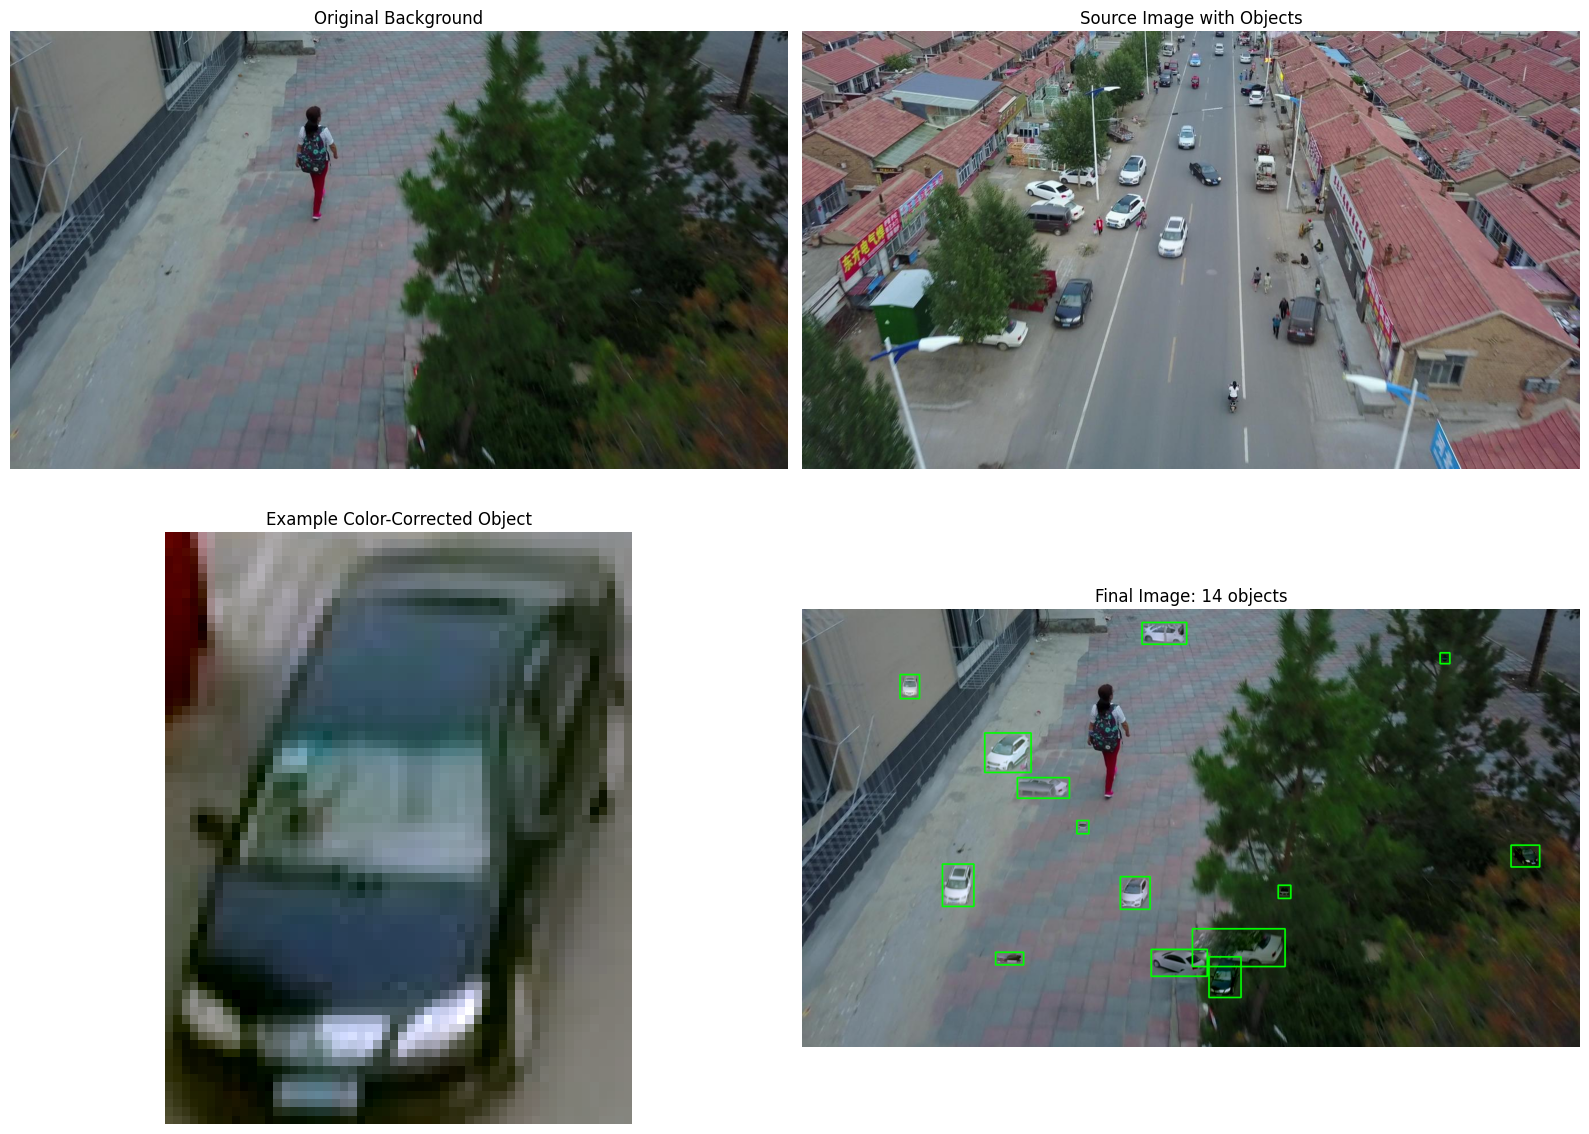

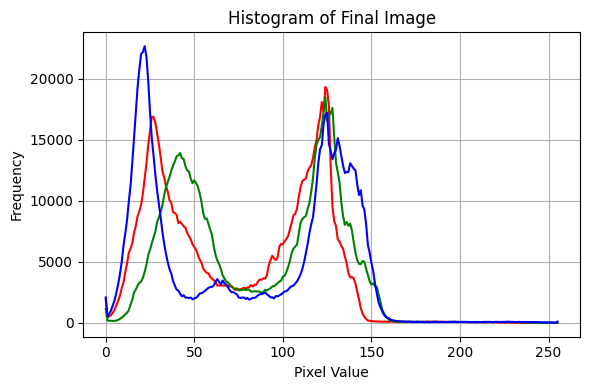

[Model] Cars Present: True, Predicted Count: 13.24, Actual Count: 14


In [52]:
def test_combined_model(model, image_paths):
    bg, src, corrected, final_img, boxes = generate_sample(image_paths, target_class=4)
    input_img = cv2.resize(final_img, (128, 128)) / 255.0
    input_img = np.expand_dims(input_img, axis=0)

    pred = model.predict(input_img)
    has_car = pred[0][0][0] > 0.5
    count_pred = pred[1][0][0]

    visualize_result(bg, src, corrected, final_img, boxes)
    print(f"[Model] Cars Present: {has_car}, Predicted Count: {count_pred:.2f}, Actual Count: {len(boxes)}")

test_combined_model(combined_model, image_files)